# Survival Analysis

In [1]:
# Import Packages:
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("StatsBase")
Pkg.add("SQLite")

┌ Error: curl_easy_setopt: 48
│ 
│ You may be using an old system libcurl library that doesn't understand options that Julia uses. You can try the following Julia code to see which libcurl library you are using:
│ 
│     using Libdl
│     filter!(contains("curl"), dllist())
│ 
│ If this indicates that Julia is not using the libcurl library that is shipped with Julia, then that is likely to be the problem. This either means:
│ 
│   1. You are using an unofficial Julia build which is configured to use a system libcurl library that is not recent enough; you may be able to fix this by upgrading the system libcurl. You should complain to your distro maintainers for allowing Julia to use a too-old libcurl version and consider using official Julia binaries instead.
│ 
│   2. You are overriding the library load path by setting `LD_LIBRARY_PATH`, in which case you are in advanced usage territory. You can try upgrading the system libcurl, unsetting `LD_LIBRARY_PATH`, or otherwise arranging for J

In [2]:
# Read the CSV File:
using CSV
using DataFrames
using Dates
using Plots

In [3]:
# Load the CSV file
file_path = "../data/AbsenceList_SampleData.csv"  # Update with the correct file path
data = CSV.File(file_path, delim='\t') |> DataFrame

Row,Full name,First name,ID,Class,Start date,Start time,End date,End time
,String15,String7,Missing,String7,String15,String15,String15,String15
1,Connor,Sarah,missing,CS101,"Sep 27, 2023",8:30 AM,"Sep 27, 2023",12:15 PM
2,Connor,Sarah,missing,CS101,"Sep 27, 2023",1:15 PM,"Sep 27, 2023",3:00 PM
3,Connor,Sarah,missing,CS101,"Sep 29, 2023",1:15 PM,"Sep 29, 2023",3:00 PM
4,Connor,Sarah,missing,CS101,"Oct 3, 2023",8:30 AM,"Oct 3, 2023",9:20 AM
5,Connor,Sarah,missing,CS101,"Oct 3, 2023",9:25 AM,"Oct 3, 2023",12:15 PM
6,Connor,Sarah,missing,CS101,"Dec 8, 2023",1:15 PM,"Dec 8, 2023",3:00 PM
7,Quaid,Douglas,missing,CS101,"Oct 3, 2023",8:55 AM,"Oct 3, 2023",9:20 AM
8,Quaid,Douglas,missing,CS101,"Oct 9, 2023",1:15 PM,"Oct 9, 2023",4:50 PM
9,Quaid,Douglas,missing,CS101,"Oct 10, 2023",8:30 AM,"Oct 10, 2023",10:15 AM


In [4]:
# Rename variable names in order to get rid of the spaces in the names
rename!(data,[:Full_name,:First_name, :ID, :Class, :Start_date, :Start_time, :End_date, :End_time])
describe(data)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Nothing,Union…,Nothing,Union…,Int64,DataType
1,Full_name,,Connor,,Walker,0,String15
2,First_name,,Douglas,,Vincent,0,String7
3,ID,,,,,50,Missing
4,Class,,CS101,,CS101,0,String7
5,Start_date,,"Dec 6, 2023",,"Sep 29, 2023",0,String15
6,Start_time,,10:30 AM,,9:25 AM,0,String15
7,End_date,,"Dec 6, 2023",,"Sep 29, 2023",0,String15
8,End_time,,10:15 AM,,9:20 AM,0,String15


## Create a new date variable for "Start date"
This step is necessary as the variable is not standard and therefore not recognized by the "Date" package.

In [5]:

# Extract the last 4 characters of "Start date" and create a new column "Year"
data[!, "Year"] = last.(string.(data[!, :Start_date]), 4)

# Extract the first 5 characters of "Start date" and create a new column "First5Chars"
data[!, "First5Chars"] = first.(string.(data[!, :Start_date]), 6)

# Remove the comma from "First5Chars" and update the column
data[!, "First5Chars"] = replace.(data[!, "First5Chars"], "," => "")

# Extract the first three characters of "First5Chars" and create a new column "Month"
data[!, "Month"] = first.(string.(data[!, "First5Chars"]), 3)

# Extract the last two characters of "First5Chars" and create a new column "Day"
data[!, "Day"] = last.(string.(data[!, "First5Chars"]), 2)


# Define a dictionary to map month abbreviations to numerical values
month_dict = Dict("Jan" => 1, "Feb" => 2, "Mar" => 3, "Apr" => 4, "May" => 5, "Jun" => 6, "Jul" => 7, "Aug" => 8, "Sep" => 9, "Oct" => 10, "Nov" => 11, "Dec" => 12)

# Create a new column "MonthNumeric" by mapping the month abbreviations to numerical values
data[!, "MonthNumeric"] = [month_dict[strip(string(month))] for month in data[!, "Month"]]

# Create a new column "NewDate" by combining "Year," "MonthNumeric," and "Day"
data[!, "StartDate"] = Dates.Date.(parse.(Int, data[!, "Year"]), data[!, "MonthNumeric"], parse.(Int, data[!, "Day"]))

# Suppose you want to delete columns "Month" and "Year"
select!(data, Not(:Month, :Year, :Day, :First5Chars, :MonthNumeric  ))


Row,Full_name,First_name,ID,Class,Start_date,Start_time,End_date,End_time,StartDate
,String15,String7,Missing,String7,String15,String15,String15,String15,Date
1,Connor,Sarah,missing,CS101,"Sep 27, 2023",8:30 AM,"Sep 27, 2023",12:15 PM,2023-09-27
2,Connor,Sarah,missing,CS101,"Sep 27, 2023",1:15 PM,"Sep 27, 2023",3:00 PM,2023-09-27
3,Connor,Sarah,missing,CS101,"Sep 29, 2023",1:15 PM,"Sep 29, 2023",3:00 PM,2023-09-29
4,Connor,Sarah,missing,CS101,"Oct 3, 2023",8:30 AM,"Oct 3, 2023",9:20 AM,2023-10-03
5,Connor,Sarah,missing,CS101,"Oct 3, 2023",9:25 AM,"Oct 3, 2023",12:15 PM,2023-10-03
6,Connor,Sarah,missing,CS101,"Dec 8, 2023",1:15 PM,"Dec 8, 2023",3:00 PM,2023-12-08
7,Quaid,Douglas,missing,CS101,"Oct 3, 2023",8:55 AM,"Oct 3, 2023",9:20 AM,2023-10-03
8,Quaid,Douglas,missing,CS101,"Oct 9, 2023",1:15 PM,"Oct 9, 2023",4:50 PM,2023-10-09
9,Quaid,Douglas,missing,CS101,"Oct 10, 2023",8:30 AM,"Oct 10, 2023",10:15 AM,2023-10-10


## Create a new date variable for "End date"
This step is necessary as the variable is not standard and therefore not recognized by the "Date" package.

In [6]:


# Extract the last 4 characters of "Start date" and create a new column "Year"
data[!, "Year"] = last.(string.(data[!, :End_date]), 4)

# Extract the first 5 characters of "Start date" and create a new column "First5Chars"
data[!, "First5Chars"] = first.(string.(data[!, :End_date]), 6)

# Remove the comma from "First5Chars" and update the column
data[!, "First5Chars"] = replace.(data[!, "First5Chars"], "," => "")

# Extract the first three characters of "First5Chars" and create a new column "Month"
data[!, "Month"] = first.(string.(data[!, "First5Chars"]), 3)

# Extract the last two characters of "First5Chars" and create a new column "Day"
data[!, "Day"] = last.(string.(data[!, "First5Chars"]), 2)


# Define a dictionary to map month abbreviations to numerical values
month_dict = Dict("Jan" => 1, "Feb" => 2, "Mar" => 3, "Apr" => 4, "May" => 5, "Jun" => 6, "Jul" => 7, "Aug" => 8, "Sep" => 9, "Oct" => 10, "Nov" => 11, "Dec" => 12)

# Create a new column "MonthNumeric" by mapping the month abbreviations to numerical values
data[!, "MonthNumeric"] = [month_dict[strip(string(month))] for month in data[!, "Month"]]

# Create a new column "NewDate" by combining "Year," "MonthNumeric," and "Day"
data[!, "EndDate"] = Dates.Date.(parse.(Int, data[!, "Year"]), data[!, "MonthNumeric"], parse.(Int, data[!, "Day"]))

# Suppose you want to delete columns "Month" and "Year"
select!(data, Not(:Month, :Year, :Day, :First5Chars, :MonthNumeric  ))


Row,Full_name,First_name,ID,Class,Start_date,Start_time,End_date,End_time,StartDate,EndDate
,String15,String7,Missing,String7,String15,String15,String15,String15,Date,Date
1,Connor,Sarah,missing,CS101,"Sep 27, 2023",8:30 AM,"Sep 27, 2023",12:15 PM,2023-09-27,2023-09-27
2,Connor,Sarah,missing,CS101,"Sep 27, 2023",1:15 PM,"Sep 27, 2023",3:00 PM,2023-09-27,2023-09-27
3,Connor,Sarah,missing,CS101,"Sep 29, 2023",1:15 PM,"Sep 29, 2023",3:00 PM,2023-09-29,2023-09-29
4,Connor,Sarah,missing,CS101,"Oct 3, 2023",8:30 AM,"Oct 3, 2023",9:20 AM,2023-10-03,2023-10-03
5,Connor,Sarah,missing,CS101,"Oct 3, 2023",9:25 AM,"Oct 3, 2023",12:15 PM,2023-10-03,2023-10-03
6,Connor,Sarah,missing,CS101,"Dec 8, 2023",1:15 PM,"Dec 8, 2023",3:00 PM,2023-12-08,2023-12-08
7,Quaid,Douglas,missing,CS101,"Oct 3, 2023",8:55 AM,"Oct 3, 2023",9:20 AM,2023-10-03,2023-10-03
8,Quaid,Douglas,missing,CS101,"Oct 9, 2023",1:15 PM,"Oct 9, 2023",4:50 PM,2023-10-09,2023-10-09
9,Quaid,Douglas,missing,CS101,"Oct 10, 2023",8:30 AM,"Oct 10, 2023",10:15 AM,2023-10-10,2023-10-10


## Create a new date variable for "Start time"
This step is necessary as the variable is not standard and therefore not recognized by the "Date" package.

In [7]:
starttime = data[!, :Start_time]
meridiem = last.(starttime,2)
time = first.(starttime,5)
hourtemp = first.(time,2)
minutetemp = last.(time,3)
minutetemp1 = replace.(minutetemp, ":" => "")
minutetemp2 = replace.(minutetemp1, " " => "")

hour = replace.(hourtemp, ":" => "")
minute = minutetemp2

data[!,"StartTimeHour"] = hour;
data[!,"StartTimeMinute"] = minute;
data[!,"StartTimeMeridiem"] = meridiem;

# Define as Time format
data[!,"time_format_str"] = hour .* ":" .* minute .* " " .* meridiem
data[!,"StartTime"] = Dates.Time.(data[!,"time_format_str"], dateformat"HH:MM p")

# Drop variables
select!(data, Not(:StartTimeHour, :StartTimeMinute, :StartTimeMeridiem, :time_format_str  ))


Row,Full_name,First_name,ID,Class,Start_date,Start_time,End_date,End_time,StartDate,EndDate,StartTime
,String15,String7,Missing,String7,String15,String15,String15,String15,Date,Date,Time
1,Connor,Sarah,missing,CS101,"Sep 27, 2023",8:30 AM,"Sep 27, 2023",12:15 PM,2023-09-27,2023-09-27,08:30:00
2,Connor,Sarah,missing,CS101,"Sep 27, 2023",1:15 PM,"Sep 27, 2023",3:00 PM,2023-09-27,2023-09-27,13:15:00
3,Connor,Sarah,missing,CS101,"Sep 29, 2023",1:15 PM,"Sep 29, 2023",3:00 PM,2023-09-29,2023-09-29,13:15:00
4,Connor,Sarah,missing,CS101,"Oct 3, 2023",8:30 AM,"Oct 3, 2023",9:20 AM,2023-10-03,2023-10-03,08:30:00
5,Connor,Sarah,missing,CS101,"Oct 3, 2023",9:25 AM,"Oct 3, 2023",12:15 PM,2023-10-03,2023-10-03,09:25:00
6,Connor,Sarah,missing,CS101,"Dec 8, 2023",1:15 PM,"Dec 8, 2023",3:00 PM,2023-12-08,2023-12-08,13:15:00
7,Quaid,Douglas,missing,CS101,"Oct 3, 2023",8:55 AM,"Oct 3, 2023",9:20 AM,2023-10-03,2023-10-03,08:55:00
8,Quaid,Douglas,missing,CS101,"Oct 9, 2023",1:15 PM,"Oct 9, 2023",4:50 PM,2023-10-09,2023-10-09,13:15:00
9,Quaid,Douglas,missing,CS101,"Oct 10, 2023",8:30 AM,"Oct 10, 2023",10:15 AM,2023-10-10,2023-10-10,08:30:00


## Create a new date variable for "End time"
This step is necessary as the variable is not standard and therefore not recognized by the "Date" package.

In [8]:
endtime = data[!, :End_time]
meridiem = last.(endtime,2)
time = first.(endtime,5)
hourtemp = first.(time,2)
minutetemp = last.(time,3)
minutetemp1 = replace.(minutetemp, ":" => "")
minutetemp2 = replace.(minutetemp1, " " => "")

hour = replace.(hourtemp, ":" => "")
minute = minutetemp2

data[!,"EndTimeHour"] = hour;
data[!,"EndTimeMinute"] = minute;
data[!,"EndTimeMeridiem"] = meridiem;

# Define as Time format
data[!,"time_format_str"] = hour .* ":" .* minute .* " " .* meridiem
data[!,"EndTime"] = Dates.Time.(data[!,"time_format_str"], dateformat"HH:MM p")

# Drop variables
select!(data, Not(:EndTimeHour, :EndTimeMinute, :EndTimeMeridiem, :time_format_str  ))

Row,Full_name,First_name,ID,Class,Start_date,Start_time,End_date,End_time,StartDate,EndDate,StartTime,EndTime
,String15,String7,Missing,String7,String15,String15,String15,String15,Date,Date,Time,Time
1,Connor,Sarah,missing,CS101,"Sep 27, 2023",8:30 AM,"Sep 27, 2023",12:15 PM,2023-09-27,2023-09-27,08:30:00,12:15:00
2,Connor,Sarah,missing,CS101,"Sep 27, 2023",1:15 PM,"Sep 27, 2023",3:00 PM,2023-09-27,2023-09-27,13:15:00,15:00:00
3,Connor,Sarah,missing,CS101,"Sep 29, 2023",1:15 PM,"Sep 29, 2023",3:00 PM,2023-09-29,2023-09-29,13:15:00,15:00:00
4,Connor,Sarah,missing,CS101,"Oct 3, 2023",8:30 AM,"Oct 3, 2023",9:20 AM,2023-10-03,2023-10-03,08:30:00,09:20:00
5,Connor,Sarah,missing,CS101,"Oct 3, 2023",9:25 AM,"Oct 3, 2023",12:15 PM,2023-10-03,2023-10-03,09:25:00,12:15:00
6,Connor,Sarah,missing,CS101,"Dec 8, 2023",1:15 PM,"Dec 8, 2023",3:00 PM,2023-12-08,2023-12-08,13:15:00,15:00:00
7,Quaid,Douglas,missing,CS101,"Oct 3, 2023",8:55 AM,"Oct 3, 2023",9:20 AM,2023-10-03,2023-10-03,08:55:00,09:20:00
8,Quaid,Douglas,missing,CS101,"Oct 9, 2023",1:15 PM,"Oct 9, 2023",4:50 PM,2023-10-09,2023-10-09,13:15:00,16:50:00
9,Quaid,Douglas,missing,CS101,"Oct 10, 2023",8:30 AM,"Oct 10, 2023",10:15 AM,2023-10-10,2023-10-10,08:30:00,10:15:00


In [9]:
data[!, "TimeMissed"] = data[!, "EndTime"] - data[!, "StartTime"] 

# Convert to minutes
data[!, "MinutesMissed"] = floor.(Int, Dates.value.(data[!, "TimeMissed"]) / (60 * 10^9))

# Drop variables
select!(data, Not(:TimeMissed ))

display(data)

Row,Full_name,First_name,ID,Class,Start_date,Start_time,End_date,End_time,StartDate,EndDate,StartTime,EndTime,MinutesMissed
,String15,String7,Missing,String7,String15,String15,String15,String15,Date,Date,Time,Time,Int64
1,Connor,Sarah,missing,CS101,"Sep 27, 2023",8:30 AM,"Sep 27, 2023",12:15 PM,2023-09-27,2023-09-27,08:30:00,12:15:00,225
2,Connor,Sarah,missing,CS101,"Sep 27, 2023",1:15 PM,"Sep 27, 2023",3:00 PM,2023-09-27,2023-09-27,13:15:00,15:00:00,105
3,Connor,Sarah,missing,CS101,"Sep 29, 2023",1:15 PM,"Sep 29, 2023",3:00 PM,2023-09-29,2023-09-29,13:15:00,15:00:00,105
4,Connor,Sarah,missing,CS101,"Oct 3, 2023",8:30 AM,"Oct 3, 2023",9:20 AM,2023-10-03,2023-10-03,08:30:00,09:20:00,50
5,Connor,Sarah,missing,CS101,"Oct 3, 2023",9:25 AM,"Oct 3, 2023",12:15 PM,2023-10-03,2023-10-03,09:25:00,12:15:00,170
6,Connor,Sarah,missing,CS101,"Dec 8, 2023",1:15 PM,"Dec 8, 2023",3:00 PM,2023-12-08,2023-12-08,13:15:00,15:00:00,105
7,Quaid,Douglas,missing,CS101,"Oct 3, 2023",8:55 AM,"Oct 3, 2023",9:20 AM,2023-10-03,2023-10-03,08:55:00,09:20:00,25
8,Quaid,Douglas,missing,CS101,"Oct 9, 2023",1:15 PM,"Oct 9, 2023",4:50 PM,2023-10-09,2023-10-09,13:15:00,16:50:00,215
9,Quaid,Douglas,missing,CS101,"Oct 10, 2023",8:30 AM,"Oct 10, 2023",10:15 AM,2023-10-10,2023-10-10,08:30:00,10:15:00,105


In [10]:
# Create a new DataFrame with the required variables
result_df = combine(groupby(data, [:Full_name, :StartDate]), :MinutesMissed => sum)

# Rename columns for clarity
rename!(result_df, :MinutesMissed_sum => :TotalMinutesMissed)

# Display the result DataFrame
display(result_df)

Row,Full_name,StartDate,TotalMinutesMissed
,String15,Date,Int64
1,Connor,2023-09-27,330
2,Connor,2023-09-29,105
3,Connor,2023-10-03,220
4,Connor,2023-12-08,105
5,Quaid,2023-10-03,25
6,Quaid,2023-10-09,215
7,Quaid,2023-10-10,210
8,Quaid,2023-10-11,2
9,Quaid,2023-10-13,20


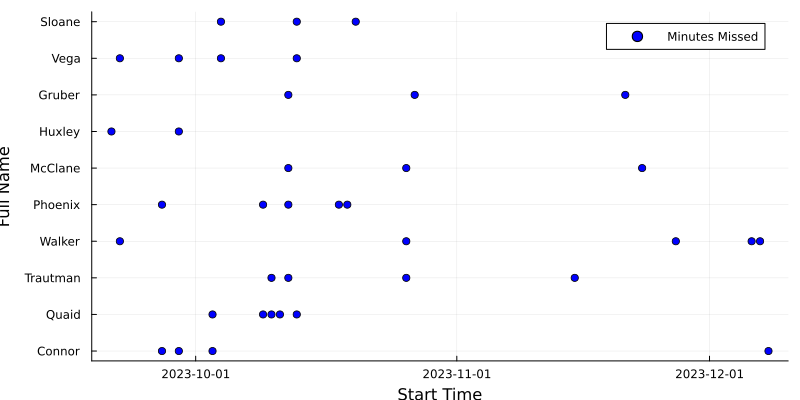

In [11]:

# Scatter plot
scatter(result_df[!, "StartDate"], result_df[!, :Full_name], size=(800, 400), marker=:circle, color=:blue, label="Minutes Missed", xlabel="Start Time", ylabel="Full Name")


In [12]:
# Group by start time and calculate the frequency for each time
time_summary = combine(groupby(result_df, :StartDate), nrow)

# Display the frequency table
display(time_summary)

Row,StartDate,nrow
,Date,Int64
1,2023-09-27,2
2,2023-09-29,3
3,2023-10-03,2
4,2023-12-08,1
5,2023-10-09,2
6,2023-10-10,2
7,2023-10-11,1
8,2023-10-13,3
9,2023-10-12,4


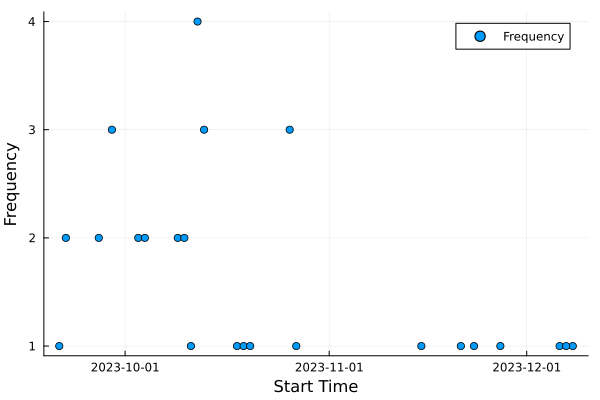

In [13]:
scatter(time_summary[!, :StartDate], time_summary[!, :nrow], xlabel="Start Time", ylabel="Frequency", label="Frequency")

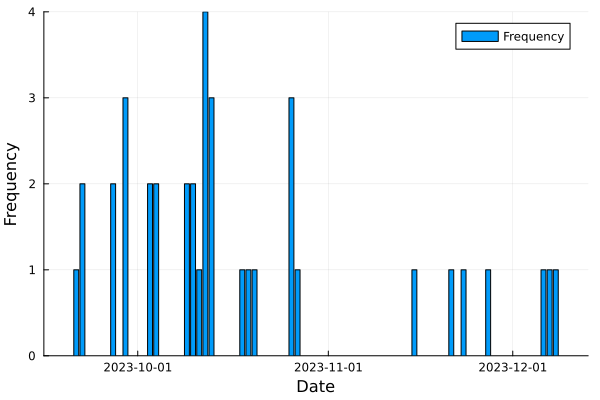

In [14]:
bar(time_summary[!, :StartDate], time_summary[!, :nrow], xlabel="Date", ylabel="Frequency", label="Frequency")


In [15]:
# Feature engineering: Extract day of the week
result_df[!, :DayOfWeek] = Dates.dayname.(Dates.Date.(result_df[!, :StartDate]))

# Filter out weekends and holidays
weekdays_df = result_df[(result_df[!, :DayOfWeek] .!= "Saturday") .& (result_df[!, :DayOfWeek] .!= "Sunday"), :]


Row,Full_name,StartDate,TotalMinutesMissed,DayOfWeek
,String15,Date,Int64,String
1,Connor,2023-09-27,330,Wednesday
2,Connor,2023-09-29,105,Friday
3,Connor,2023-10-03,220,Tuesday
4,Connor,2023-12-08,105,Friday
5,Quaid,2023-10-03,25,Tuesday
6,Quaid,2023-10-09,215,Monday
7,Quaid,2023-10-10,210,Tuesday
8,Quaid,2023-10-11,2,Wednesday
9,Quaid,2023-10-13,20,Friday


In [81]:
# Group by student and weekday and count absences
grouped_df = groupby(weekdays_df, [:Full_name, :DayOfWeek])
count_df = combine(grouped_df, :TotalMinutesMissed => sum => :AbsenceCount)

Row,Full_name,DayOfWeek,AbsenceCount
,String15,String,Int64
1,Connor,Wednesday,330
2,Connor,Friday,210
3,Connor,Tuesday,220
4,Quaid,Tuesday,235
5,Quaid,Monday,215
6,Quaid,Wednesday,2
7,Quaid,Friday,20
8,Trautman,Tuesday,36
9,Trautman,Thursday,325


In [16]:
# Find the weekday with the maximum absences for each student
max_absence_day_df = combine(groupby(count_df, :Full_name), :AbsenceCount => argmax => :DayOfWeek, :AbsenceCount => maximum => :MaxAbsences)

# Add a column with the corresponding weekday
max_absence_day_df[!, :Weekday] = Dates.dayname.(Dates.Date.(max_absence_day_df[!, :DayOfWeek]))

# Display the result
display(max_absence_day_df)

LoadError: UndefVarError: `count_df` not defined

In [83]:
# Create a DataFrame with all the dates you want to include
all_dates = DataFrame(StartDate = Date(2023, 9, 19):Date(2023, 12, 15))

# Filter weekdays
all_dates = filter(row -> Dates.dayofweek(row.StartDate) in 2:6, all_dates)

Row,StartDate
,Date
1,2023-09-19
2,2023-09-20
3,2023-09-21
4,2023-09-22
5,2023-09-23
6,2023-09-26
7,2023-09-27
8,2023-09-28
9,2023-09-29


In [17]:
describe(result_df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Any,Any,Int64,DataType
1,Full_name,,Connor,,Walker,0,String15
2,StartDate,,2023-09-21,2023-10-12,2023-12-08,0,Date
3,TotalMinutesMissed,154.289,2,105.0,610,0,Int64
4,DayOfWeek,,Friday,,Wednesday,0,String


## Create a database with all school days

In [18]:
display(result_df)

Row,Full_name,StartDate,TotalMinutesMissed,DayOfWeek
,String15,Date,Int64,String
1,Connor,2023-09-27,330,Wednesday
2,Connor,2023-09-29,105,Friday
3,Connor,2023-10-03,220,Tuesday
4,Connor,2023-12-08,105,Friday
5,Quaid,2023-10-03,25,Tuesday
6,Quaid,2023-10-09,215,Monday
7,Quaid,2023-10-10,210,Tuesday
8,Quaid,2023-10-11,2,Wednesday
9,Quaid,2023-10-13,20,Friday


In [20]:
using DataFrames
using Dates

# Rename the DataFrame
df = result_df

# Keep only the rows where DayOfWeek is "Friday"
df_filtered = filter(row -> row.:Full_name == "Connor", df)

Row,Full_name,StartDate,TotalMinutesMissed,DayOfWeek
,String15,Date,Int64,String
1,Connor,2023-09-27,330,Wednesday
2,Connor,2023-09-29,105,Friday
3,Connor,2023-10-03,220,Tuesday
4,Connor,2023-12-08,105,Friday


## Create database of abseces : binary variable (0=no absence; 1=absence)

In [21]:
using DataFrames
using Dates

# Define the input DataFrame
df_full = DataFrame(
    Full_name = String[],
    StartDate = Date[],
    TotalMinutesMissed = Int64[],
    DayOfWeek = String[]
)

# Define the date range
date_range = Date(2023, 9, 27):Day(1):Date(2023, 12, 8)

# Populate the DataFrame with the specified formats
for date in date_range
    push!(df_full, [
        "Last01",
        date,
        0,
        Dates.format(date, "EEEE")
    ])
end

df_full = filter(row -> row.DayOfWeek != "Saturday" && row.DayOfWeek != "Sunday", df_full)


# Print the resulting DataFrame
println(df_full)


53×4 DataFrame
 Row │ Full_name  StartDate   TotalMinutesMissed  DayOfWeek 
     │ String     Date        Int64               String    
─────┼──────────────────────────────────────────────────────
   1 │ Last01     2023-09-27                   0  Wednesday
   2 │ Last01     2023-09-28                   0  Thursday
   3 │ Last01     2023-09-29                   0  Friday
   4 │ Last01     2023-10-02                   0  Monday
   5 │ Last01     2023-10-03                   0  Tuesday
   6 │ Last01     2023-10-04                   0  Wednesday
   7 │ Last01     2023-10-05                   0  Thursday
   8 │ Last01     2023-10-06                   0  Friday
   9 │ Last01     2023-10-09                   0  Monday
  10 │ Last01     2023-10-10                   0  Tuesday
  11 │ Last01     2023-10-11                   0  Wednesday
  12 │ Last01     2023-10-12                   0  Thursday
  13 │ Last01     2023-10-13                   0  Friday
  14 │ Last01     2023-10-16                

In [22]:
# Merge DataFrame A into DataFrame B, overwriting values in B with values in A
#df_complete = join(df_full, df_filtered, on = :TotalMinutesMissed, kind = :left, makeunique = true)

#df_complete = innerjoin(df_full, df_filtered, on = :TotalMinutesMissed, makeunique=true)

merged = outerjoin(df_full, df_filtered, on = :StartDate, makeunique=true)


Row,Full_name,StartDate,TotalMinutesMissed,DayOfWeek,Full_name_1,TotalMinutesMissed_1,DayOfWeek_1
,String?,Date,Int64?,String?,String15?,Int64?,String?
1,Last01,2023-09-27,0,Wednesday,Connor,330,Wednesday
2,Last01,2023-09-29,0,Friday,Connor,105,Friday
3,Last01,2023-10-03,0,Tuesday,Connor,220,Tuesday
4,Last01,2023-12-08,0,Friday,Connor,105,Friday
5,Last01,2023-09-28,0,Thursday,missing,missing,missing
6,Last01,2023-10-02,0,Monday,missing,missing,missing
7,Last01,2023-10-04,0,Wednesday,missing,missing,missing
8,Last01,2023-10-05,0,Thursday,missing,missing,missing
9,Last01,2023-10-06,0,Friday,missing,missing,missing


## Create new binary variable : 0 = "no absence" , 1 = "absent"

In [36]:
# Create a new binary variable
 
function create_binary_variable(variableA)
  new_variable = fill(0, length(variableA))
  for i in 1:length(variableA)
    if ismissing(variableA[i])
      new_variable[i] = 0
    else
      new_variable[i] = 1
    end
  end
  return new_variable
end

merged[!,:absences] = create_binary_variable(merged.DayOfWeek_1)

merged_absences = merged

select!(merged_absences, Not(:TotalMinutesMissed, :Full_name_1	, :TotalMinutesMissed_1, :DayOfWeek_1  ))

display(merged_absences)

Row,Full_name,StartDate,DayOfWeek,absences
,String?,Date,String?,Int64
1,Last01,2023-09-27,Wednesday,1
2,Last01,2023-09-29,Friday,1
3,Last01,2023-10-03,Tuesday,1
4,Last01,2023-12-08,Friday,1
5,Last01,2023-09-28,Thursday,0
6,Last01,2023-10-02,Monday,0
7,Last01,2023-10-04,Wednesday,0
8,Last01,2023-10-05,Thursday,0
9,Last01,2023-10-06,Friday,0


## Compute transition matrix

Use the another set of data for this.

# SANDBOX

## [Merge two tables together and overwrite exisiting values with SQL](https://stackoverflow.com/questions/38958166/merge-two-tables-together-and-overwrite-exisiting-values-with-sql)

I try to merge two tables together and want to get a single table with SQL. My main problem is to overwrite existing values, because in the 2nd table (deltaTable) are some new revision rows, that have the same ID as in the first table (rootTable).

**Example:**

**1) rootTable**

ID | REV | NAME   |
---|-----|--------|
 1 |   0 | Part 1 |
 2 |   0 | Part 2 |
 3 |   0 | Part 3 |
 4 |   0 | Part 4 |
 5 |   0 | Part 5 |

**2) deltaTable**
 
ID | REV | NAME       |
---|-----|------------|
 2 |   1 | Part 2     |
 4 |   2 | New Part 4 |

**I want to have the following result:**

ID | REV | NAME       |
---|-----|------------|
 1 |   0 | Part 1     |
 2 |   1 | Part 2     |
 3 |   0 | Part 3     |
 4 |   2 | New Part 4 |
 5 |   0 | Part 5     |




The SQL code would be :

```sql
update
  rootTable r inner join deltaTable d
  on r.id = d.id
set
  r.REV = d.REV,
  r.NAME = d.NAME
```

or 

```sql
insert into rootTable (ID, REV, NAME)
select * from deltaTable
on duplicate key update
  REV=values(REV), NAME=values(NAME);
```



In [89]:
## NOT WORKING!!!

using DataFrames

# Create two dataframes
rootTable = DataFrame(id = [1, 2, 3, 4, 5], rev = [0, 0, 0, 0, 0], name = ["Part 1", "Part 2", "Part 3", "Part 4", "Part 5"])
deltaTable = DataFrame(id = [2, 4], rev = [1, 2], name = ["Part 2", "New Part 4"])

# Merge the two dataframes
merged = innerjoin(rootTable, deltaTable, on = :id, makeunique=true)

# Update the values of REV and NAME in rootTable
merged.rev[:] = merged.rev_1
merged.name[:] = merged.name_1

# Update the original rootTable with the modified values
not = ~
keep_rows = [i for i in 1:nrow(merged) if not(ismissing(merged[i, :rev_1]) && ismissing(merged[i, :name_1]))]

rootTable = merged[keep_rows, :]

# Print the updated rootTable
print(rootTable)

2×5 DataFrame
 Row │ id     rev    name        rev_1  name_1     
     │ Int64  Int64  String      Int64  String     
─────┼─────────────────────────────────────────────
   1 │     2      1  Part 2          1  Part 2
   2 │     4      2  New Part 4      2  New Part 4

In [90]:
## NOT WORKING

using DataFrames

# Create two dataframes
rootTable = DataFrame(id = [1, 2, 3, 4, 5], rev = [0, 0, 0, 0, 0], name = ["Part 1", "Part 2", "Part 3", "Part 4", "Part 5"])
deltaTable = DataFrame(id = [2, 4], rev = [1, 2], name = ["Part 2", "New Part 4"])

# Insert data from deltaTable into rootTable
for i in 1:size(deltaTable, 1)
    id = deltaTable[i, :id]
    rev = deltaTable[i, :rev]
    name = deltaTable[i, :name]
    if id in rootTable.id
        rootTable[findall(x -> x == id, rootTable.id), [:rev, :name]] .= [rev, name]
    else
        push!(rootTable, [id, rev, name])
    end
end



LoadError: DimensionMismatch: array could not be broadcast to match destination

In [91]:
using DataFrames

# Create two dataframes
df_a = DataFrame(A = [1, 2], B = [4, 5])
df_b = DataFrame(A = [1, 2, 3], B = [4, 11, 6])

# Merge the two dataframes
merged = outerjoin(df_a, df_b, on = :A, makeunique=true)

# Print the merged dataframe
print(merged)

3×3 DataFrame
 Row │ A      B        B_1    
     │ Int64  Int64?   Int64? 
─────┼────────────────────────
   1 │     1        4       4
   2 │     2        5      11
   3 │     3  missing       6